In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

In [6]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)

df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [7]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [8]:
df_spectra_bc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_BC.csv',sep=',', index_col=0)
df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
df_spectra_wc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_WC.csv',sep=',', index_col=0)

df_spectra_bc.columns = ['a' + col for col in df_spectra_bc.columns]
df_spectra_pw.columns = ['a' + col for col in df_spectra_bc.columns]
df_spectra_wc.columns = ['a' + col for col in df_spectra_bc.columns]

In [9]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [10]:
#Put all the BC data together 
#remove repeat rows 
df_cdom_bc_cl = df_cdom_bc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged','file_id'], axis=1)
df_iron_bc_cl = df_iron_bc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_bc = df_spectra_bc.join(df_doc_bc)
df_bc = df_bc.join(df_cdom_bc_cl)

#match up the inxdes for the merge 
df_iron_bc_cl['sample_index'] = df_iron_bc_cl.index.astype(str)
df_bc.index = df_bc.index.astype(str)

#combind the iron data 
df_bc = df_bc.join(df_iron_bc_cl)

#Put all the PW data together 
#remove repeat rows 
df_cdom_pw_cl = df_cdom_pw.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_pw_cl = df_iron_pw.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_pw = df_spectra_pw.join(df_doc_pw)
df_pw = df_pw.join(df_cdom_pw_cl)

#match up the inxdes for the merge 
df_iron_pw_cl['sample_index'] = df_iron_pw_cl.index.astype(str)
df_pw.index = df_pw.index.astype(str)

#combind the iron data 
df_pw = df_pw.join(df_iron_pw_cl)

#Put all the WC data together 
#remove repeat rows 
df_cdom_wc_cl = df_cdom_wc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_wc_cl = df_iron_wc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_wc = df_spectra_wc.join(df_doc_wc)
df_wc = df_wc.join(df_cdom_wc_cl)

#match up the inxdes for the merge 
df_iron_wc_cl['sample_index'] = df_iron_wc_cl.index.astype(str)
df_wc.index = df_wc.index.astype(str)

#combind the iron data 
df_wc = df_wc.join(df_iron_wc_cl)


In [36]:
for col in df_bc.columns:
    print(col)


a250
a251
a252
a253
a254
a255
a256
a257
a258
a259
a260
a261
a262
a263
a264
a265
a266
a267
a268
a269
a270
a271
a272
a273
a274
a275
a276
a277
a278
a279
a280
a281
a282
a283
a284
a285
a286
a287
a288
a289
a290
a291
a292
a293
a294
a295
a296
a297
a298
a299
a300
a301
a302
a303
a304
a305
a306
a307
a308
a309
a310
a311
a312
a313
a314
a315
a316
a317
a318
a319
a320
a321
a322
a323
a324
a325
a326
a327
a328
a329
a330
a331
a332
a333
a334
a335
a336
a337
a338
a339
a340
a341
a342
a343
a344
a345
a346
a347
a348
a349
a350
a351
a352
a353
a354
a355
a356
a357
a358
a359
a360
a361
a362
a363
a364
a365
a366
a367
a368
a369
a370
a371
a372
a373
a374
a375
a376
a377
a378
a379
a380
a381
a382
a383
a384
a385
a386
a387
a388
a389
a390
a391
a392
a393
a394
a395
a396
a397
a398
a399
a400
a401
a402
a403
a404
a405
a406
a407
a408
a409
a410
a411
a412
a413
a414
a415
a416
a417
a418
a419
a420
a421
a422
a423
a424
a425
a426
a427
a428
a429
a430
a431
a432
a433
a434
a435
a436
a437
a438
a439
a440
a441
a442
a443
a444
a445
a446
a447
a448
a449


                            OLS Regression Results                            
Dep. Variable:                   a350   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     90.32
Date:                Wed, 06 Sep 2023   Prob (F-statistic):          9.44e-121
Time:                        21:22:35   Log-Likelihood:                -861.88
No. Observations:                3294   AIC:                             1740.
Df Residuals:                    3286   BIC:                             1789.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.00

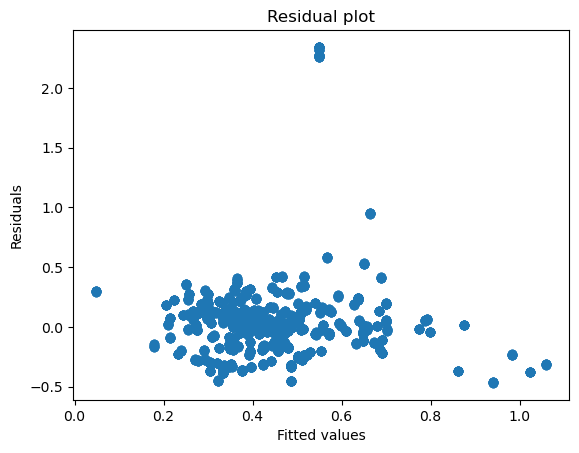

                           sum_sq      df           F        PR(>F)
Intercept                0.000032     1.0    0.000319  9.857582e-01
NPOC_uM                 24.410362     1.0  246.447281  1.307519e-53
Fe2_uM                   0.605184     1.0    6.109945  1.349264e-02
NPOC_uM:Fe2_uM           0.833803     1.0    8.418080  3.739770e-03
Fe3_uM                   6.522301     1.0   65.849223  6.807537e-16
NPOC_uM:Fe3_uM           3.804568     1.0   38.410958  6.443130e-10
Fe2_uM:Fe3_uM            5.126781     1.0   51.760037  7.732886e-13
NPOC_uM:Fe2_uM:Fe3_uM    4.835358     1.0   48.817822  3.385792e-12
Residual               325.475086  3286.0         NaN           NaN


In [26]:
#WATER COLUMN
# Define the model formula
formula = 'a350 ~ NPOC_uM*Fe2_uM*Fe3_uM'

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_bc).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)
